## The Battle of The Neighborhoods

This project is made for the final submission of Data Science Capstone, a course on Coursera by IBM. 

In [1]:
import pandas as pd
import numpy as np
import folium
import pickle as pkl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import requests
from geopy.geocoders import Nominatim

In [2]:
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


<b>Problem Statement: </b>The aim is to open a new Pizza Place in the city of Toronto, Canada. The constraints to be applied are:
1. The neighborhood should not have much competition
2. If the first condition is met, the place with most pedestrian volumes in the day should be selected

Let's start by collecting the required data

#### Pedestrian Density Dataset of Toronto with Coordinates of Intersections

In [3]:
#df_pedestrian = pd.read_csv('pedestrian_density.csv')
df_pedestrian = pd.read_csv('pedestrian_density_neighborhood.csv')

Finding out the Neighborhoods of intersections

In [4]:
neighborhood = []

opened = False

try:
    with open('neighborhoods.pkl', 'rb') as f:
        neighborhood = pkl.load(f)
    print("Neighborhoods Loaded Successfuly..")
    opened = True
except:
    pass

if not opened:
    for lat, lng in zip(df_pedestrian['Latitude'], df_pedestrian['Longitude']):
        geolocator = Nominatim()
        g = geolocator.reverse("{}, {}".format(lat, lng), timeout=10)
        try:
            neighborhood.append(g.raw['address']['neighbourhood'])
        except KeyError:
            neighborhood.append(0)
            
    with open('neighborhoods.pkl', 'wb') as f:
        pkl.dump(neighborhoods, f)

C:\Users\singh\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  from ipykernel import kernelapp as app


KeyboardInterrupt: 

In [ ]:
df_pedestrian['neighborhood'] = neighborhood

Selecting relevant columns and renaming them

In [4]:
df_pedestrian = df_pedestrian[['Main', 'Side 1 Route', 'Latitude', 'Longitude', '8 Peak Hr Pedestrian Volume', 'neighborhood']]

In [5]:
df_pedestrian.columns = ['main', 'side_1_route', 'latitude', 'longitude', 'pedestrian_volume', 'neighborhood']
df_pedestrian.head()

,main,side_1_route,latitude,longitude,pedestrian_volume,neighborhood
0,JARVIS ST,FRONT ST E,43.649418,-79.371446,13535,St. Lawrence
1,KING ST E,JARVIS ST,43.650461,-79.371924,7333,St. Lawrence
2,JARVIS ST,ADELAIDE ST E,43.651534,-79.372360,7083,St. Lawrence
3,JARVIS ST,RICHMOND ST E,43.652718,-79.372824,4369,King East
4,JARVIS ST,QUEEN ST E,43.653704,-79.373238,3368,King East


There were some locations for which couldn't get neighborhood names. So to solve this issue, we will consider their city district instead, and for those locations that we couldn't find the city district, we will just take the main street name for those locations.

In [6]:
df_neigh = df_pedestrian[df_pedestrian['neighborhood'] == '0']

In [7]:
city_district = []

opened = False

try:
    with open('districts.pkl', 'rb') as f:
        city_district = pkl.load(f)
    print("District Data Loaded..")
    opened = True
except:
    pass

if not opened:
    for lat, lng in zip(df_neigh['latitude'], df_neigh['longitude']):
        geolocator = Nominatim(user_agent='NeighborhoodAnalysis')
        g = geolocator.reverse("{}, {}".format(lat, lng), timeout=10)
        try:
            city_district.append(g.raw['address']['city_district'])
        except KeyError:
            city_district.append(0)
    
    with open('districts.pkl', 'wb') as f:
        pkl.dump(city_district, f)

District Data Loaded..


In [8]:
df_neigh['neighborhood'] = city_district

C:\Users\singh\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [9]:
df_missing = df_neigh[df_neigh['neighborhood'] == 0]

In [10]:
df_missing['neighborhood'] = df_neigh['main']

C:\Users\singh\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Putting those missing neighborhoods in pedestrian dataframe

In [11]:
for neigh, i in zip(df_neigh['neighborhood'], df_neigh.index):
    df_pedestrian.iloc[i, -1] = neigh

for neigh, i in zip(df_missing['neighborhood'], df_missing.index):
    df_pedestrian.iloc[i, -1] = neigh

Drop remaining unnecessary columns

In [12]:
df_pedestrian.drop(['main', 'side_1_route'], axis=1, inplace=True)

Grouping the dataframe by neighborhoods. We will take the average of all the latitudes and longitudes of same neighborhood, and take the sum of all the number of pedestrians passing by the neighborhood.

In [13]:
func = {'latitude':'mean', 'longitude':'mean', 'pedestrian_volume':'sum'}

In [14]:
df_grouped = df_pedestrian.groupby(df_pedestrian['neighborhood']).aggregate(func)

In [15]:
df_grouped = df_grouped.reset_index()

Maximum number of people passing by..

In [17]:
df_grouped[df_grouped['pedestrian_volume'] == df_grouped.pedestrian_volume.max()]

,neighborhood,latitude,longitude,pedestrian_volume
76,Entertainment District,43.647398,-79.388537,267667


Exporting the grouped dataframe to save all the computations for later

In [18]:
df_grouped.to_csv('final_clean_df.csv')

Getting coordinates of Toronto, Ontario for visualization

In [19]:
geocoder = Nominatim(user_agent='NeighborhoodAnalysis')
g = geocoder.geocode('Toronto, Ontario')

t_latitude = g.latitude
t_longitude = g.longitude

print("Latitude and Logitude of Toronto, Ontario are: {}, {}".format(t_latitude, t_longitude))

Latitude and Logitude of Toronto, Ontario are: 43.653963, -79.387207


Visualizing the neighborhoods calculated so far

In [20]:
toronto_map = folium.Map(location=[t_latitude, t_longitude], zoom_start=11)

for lat, lng in zip(df_grouped['latitude'], df_grouped['longitude']):
    folium.CircleMarker(
    [lat, lng],
    radius=5,
    color='red',
    fill=True,
    fill_color = 'red',
    fill_opactiy = 0.3).add_to(toronto_map)

toronto_map

Normalizing pedestrian volumes for visualizing map of toronto considering the number of people passing by a neighborhood. (Red to Violet -> Max to Min number of people)

In [21]:
df_grouped['pedestrian_volume_normalised'] = df_grouped['pedestrian_volume']/df_grouped['pedestrian_volume'].max()

In [22]:
toronto_map = folium.Map(location=[t_latitude, t_longitude], zoom_start=11)

colors_array = cm.rainbow(df_grouped['pedestrian_volume_normalised'])
rainbow = [colors.rgb2hex(i) for i in colors_array]

for lat, lng, neigh, vol, color, num in zip(df_grouped['latitude'], df_grouped['longitude'], df_grouped['neighborhood'], df_grouped['pedestrian_volume_normalised'], rainbow, df_grouped['pedestrian_volume']):
    label = folium.Popup(str(neigh) + ":" + str(num), parse_html=True)
    folium.CircleMarker(
    [lat, lng],
    radius=(vol+0.2)*10,
    popup=label,
    color=color,
    fill=True,
    fill_color=color,
    fill_opactiy = 0.3).add_to(toronto_map)

toronto_map

Box plot of pedestrian volume to find out the outliers in dataset

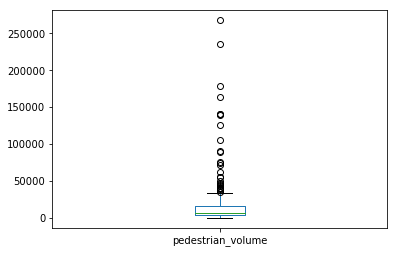

In [23]:
df_grouped['pedestrian_volume'].plot(kind='box')
plt.show()

## Foursquare API Data Collection

Foursquare Credentials

In [24]:
CLIENT_ID = 'RWINEW5YS0D3ONXTR4G1RPH2PAEQRTNFWMSFA001KFW1LGSB'
CLIENT_SECRET = 'QQYGBVSIM1YSVXAO3ENP4NN2VJKIDICEKJSLWICYW0RDGPQ3'
VERSION = '20180605'

print('Credentials: \nClient ID: {}\nClient Secret: {}\nVersion: {}'.format(CLIENT_ID, CLIENT_SECRET, VERSION))

Credentials: 
Client ID: RWINEW5YS0D3ONXTR4G1RPH2PAEQRTNFWMSFA001KFW1LGSB
Client Secret: QQYGBVSIM1YSVXAO3ENP4NN2VJKIDICEKJSLWICYW0RDGPQ3
Version: 20180605


Get venues in the neighborhoods in 500 meter range

In [27]:
def get_nearby_venues(names, latitude, longitude, radius=500, LIMIT=100):
    
    opened = False
    try:
        nearby_venues = pd.read_csv('venue_data_toronto.csv')
        print("Venue Data Loaded..")
        opened = True
    except:
        pass
    
    if not opened:
        venues_list = []
        for name,  lat, long in zip(names, latitude, longitude):
            print('\n\nProcessing Neighborhood: ', name)
            url = "https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat, long,
            radius,
            LIMIT)

            results = requests.get(url).json()['response']['groups'][0]['items']

            venues_list.append([(
            name,
            lat,
            long,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

            nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
            nearby_venues.columns=['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']

            print('Done: ', name)
        nearby_venues.to_csv('venue_data_toronto.csv', index=False)
        
    return nearby_venues

In [29]:
toronto_venues = get_nearby_venues(names = df_grouped['neighborhood'], 
                                   latitude = df_grouped['latitude'], 
                                   longitude = df_grouped['longitude'],
                                  radius=500)



Processing Neighborhood:  Agincourt
Done:  Agincourt


Processing Neighborhood:  Agincourt Centre
Done:  Agincourt Centre


Processing Neighborhood:  Agincourt North
Done:  Agincourt North


Processing Neighborhood:  Alderwood
Done:  Alderwood


Processing Neighborhood:  Alexandra Park
Done:  Alexandra Park


Processing Neighborhood:  Armadale
Done:  Armadale


Processing Neighborhood:  Armour Heights
Done:  Armour Heights


Processing Neighborhood:  Bathurst Quay
Done:  Bathurst Quay


Processing Neighborhood:  Bayview Village
Done:  Bayview Village


Processing Neighborhood:  Bayview Woods-Steeles
Done:  Bayview Woods-Steeles


Processing Neighborhood:  Beach Hill
Done:  Beach Hill


Processing Neighborhood:  Beaches—East York
Done:  Beaches—East York


Processing Neighborhood:  Beaumonde Heights
Done:  Beaumonde Heights


Processing Neighborhood:  Bedford Park
Done:  Bedford Park


Processing Neighborhood:  Bendale
Done:  Bendale


Processing Neighborhood:  Bennington Heights
Done

Done:  Lawrence Park


Processing Neighborhood:  Leaside
Done:  Leaside


Processing Neighborhood:  Leaside Business Park
Done:  Leaside Business Park


Processing Neighborhood:  Leslieville
Done:  Leslieville


Processing Neighborhood:  Liberty Village
Done:  Liberty Village


Processing Neighborhood:  Little Italy
Done:  Little Italy


Processing Neighborhood:  Little Jamaica
Done:  Little Jamaica


Processing Neighborhood:  Little Malta
Done:  Little Malta


Processing Neighborhood:  Little Portugal
Done:  Little Portugal


Processing Neighborhood:  Little Tibet
Done:  Little Tibet


Processing Neighborhood:  Little Tokyo
Done:  Little Tokyo


Processing Neighborhood:  Long Branch
Done:  Long Branch


Processing Neighborhood:  Lytton Park
Done:  Lytton Park


Processing Neighborhood:  Malvern
Done:  Malvern


Processing Neighborhood:  Malvern West
Done:  Malvern West


Processing Neighborhood:  Maple Leaf
Done:  Maple Leaf


Processing Neighborhood:  Markland Woods
Done:  Markland W

Done:  YONGE ST


Processing Neighborhood:  Yonge & Eglinton
Done:  Yonge & Eglinton


Processing Neighborhood:  York Centre
Done:  York Centre


Processing Neighborhood:  York Heights
Done:  York Heights


Processing Neighborhood:  York Mills
Done:  York Mills


Processing Neighborhood:  York South—Weston
Done:  York South—Weston


Processing Neighborhood:  Yorkville
Done:  Yorkville


Filering out only the competitors and finding out the number of competitors in each neighborhood

In [30]:
blacklist = ['Fast Food Restaurant', 'Burrito Place', 'Pizza Place', 'Fried Chicken Joint', 'Wings Joint', 'Taco Place', 'Food Court', 'Burger Joint', 'BBQ Joint', 'Mac & Cheese Joint']
venues = toronto_venues[toronto_venues['Venue Category'].isin(blacklist)]

In [31]:
one_hot_venues = pd.get_dummies(venues['Venue Category'])
one_hot_venues['competitions'] = one_hot_venues.sum(axis=1)

one_hot_venues['neighborhood'] = venues['Neighborhood']

In [32]:
compete = one_hot_venues.groupby('neighborhood').sum()
compete = compete.reset_index()
compete = compete[['neighborhood', 'competitions']]

In [33]:
compete.head()

,neighborhood,competitions
0,Agincourt Centre,5
1,Agincourt North,5
2,Alexandra Park,6
3,Armadale,4
4,Bayview Village,1


Adding the number of competitors to pedestrian volume dataframe and setting those having no competition to 0

In [35]:
merged_df = df_grouped.join(compete.set_index('neighborhood'), on='neighborhood')
merged_df = merged_df.replace(np.nan, 0)

In [36]:
merged_df.head()

,neighborhood,latitude,longitude,pedestrian_volume,pedestrian_volume_normalised,competitions
0,Agincourt,43.794101,-79.282192,1104,0.004125,0.0
1,Agincourt Centre,43.781529,-79.288070,7958,0.029731,5.0
2,Agincourt North,43.808548,-79.270792,17440,0.065156,5.0
3,Alderwood,43.611252,-79.546050,3545,0.013244,0.0
4,Alexandra Park,43.648064,-79.404321,13032,0.048687,6.0


Finding out outliers in the competition

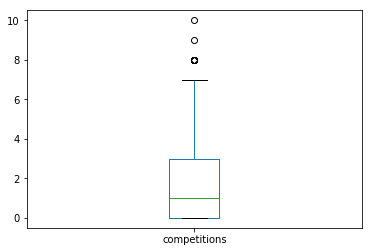

In [39]:
merged_df['competitions'].plot(kind='box')
plt.show()

Printing place with maximum number of competitions (We are obviously not considering this place for opening)

In [40]:
merged_df[merged_df['competitions'] == merged_df.competitions.max()]

,neighborhood,latitude,longitude,pedestrian_volume,pedestrian_volume_normalised,competitions
76,Entertainment District,43.647398,-79.388537,267667,1.0,10.0


In [49]:
merged_df.describe()

,latitude,longitude,pedestrian_volume,pedestrian_volume_normalised,competitions
count,268.000000,268.000000,268.000000,268.000000,268.000000
mean,43.705675,-79.384901,16930.932836,0.063254,1.798507
std,0.055046,0.209985,32877.567283,0.122830,2.113909
min,43.592941,-79.601589,4.000000,0.000015,0.000000
25%,43.661648,-79.474710,3407.500000,0.012730,0.000000
50%,43.695117,-79.395048,6796.000000,0.025390,1.000000
75%,43.749088,-79.326056,15661.000000,0.058509,3.000000
max,43.842590,-76.404853,267667.000000,1.000000,10.000000


75% of the pedestrian volume is smaller than 15661, so we are setting the threshold for pedestrian volume at <b>15000 or more persons per day.</b>
We can also observe that around 75% of the places have less than 3 places in competition with our type of restaurant, so we can set a threshold of <b>3 or less competitions.</b>

In [54]:
recommended_df = merged_df[merged_df['competitions'] < 4]
recommended_df = recommended_df[recommended_df['pedestrian_volume'] > 15000]

In [62]:
recommended_df = recommended_df.sort_values('pedestrian_volume', ascending=False)
recommended_df.reset_index(inplace=True, drop=True)
recommended_df = recommended_df.head(20)

Visualizing the recommendations on map (Red to Violet -> Most to Least recommended)

In [68]:
recommended_map = folium.Map(location=[t_latitude, t_longitude], zoom_start=11)

colors_array = cm.rainbow(np.linspace(0, 1, len(recommended_df['pedestrian_volume_normalised'])))
rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbow = rainbow[::-1]

for lat, lng, neigh, vol, comp, color in zip(recommended_df['latitude'], recommended_df['longitude'], recommended_df['neighborhood'], recommended_df['pedestrian_volume'], recommended_df['competitions'], rainbow):
    label = folium.Popup(str(neigh) + "\nComp: " + str(comp) + "\nPeople: " + str(vol), parse_html=True)
    folium.CircleMarker(
    [lat, lng],
    popup=label,
    color=color,
    radius=5,
    fill=True,
    fill_color=color,
    fill_opacity=0.5).add_to(recommended_map)
    
recommended_map

In [67]:
recommended_df

,neighborhood,latitude,longitude,pedestrian_volume,pedestrian_volume_normalised,competitions
0,Yorkville,43.672921,-79.387936,163569,0.611091,3.0
1,King East,43.650648,-79.375515,141290,0.527857,3.0
2,Bloor Street Culture Corridor,43.667084,-79.395838,126610,0.473013,1.0
3,Discovery District,43.658712,-79.389269,105377,0.393687,2.0
4,Lansing,43.766599,-79.417980,89758,0.335335,1.0
5,University—Rosedale,43.671521,-79.392458,62323,0.232838,2.0
6,Parkdale—High Park,43.650713,-79.460926,55316,0.206660,1.0
7,South Core,43.642590,-79.375996,43763,0.163498,1.0
8,The Annex,43.667669,-79.404026,40854,0.152630,2.0
9,Jane & Finch,43.760842,-79.515553,40555,0.151513,2.0
